# 🧠 Build Your Dream Computer: A Generative AI Assistant for Planning PC Builds 💻✨

Welcome to the **PC Builder Assistant** notebook — your AI-powered companion for navigating the complex world of custom and pre-built PCs. Whether you're a gamer, content creator, office user, or machine learning enthusiast, this assistant is designed to help you discover the **best machine for your needs and your budget**.

[![PCBuilderBot](https://i.imgur.com/NY3g3FM.png)](https://imgur.com/a/pc-builder-bot-EMvbcxL)

Made as the final Capstone Project submission for the [Google x Kaggle Generative AI Hackathon](https://www.kaggle.com/competitions/gen-ai-intensive-course-capstone-2025q1) held in April 2025.

## 💡 The Problem

Choosing the right computer — whether it's a prebuilt device or a custom-built rig — is **overwhelming**. You need to consider use cases, compatible components, budget constraints, power draw, hardware bottlenecks, and a sea of ever-changing product options.

This is especially hard for non-technical users, or those who don’t keep up with the latest PC hardware trends.

---

## 🧙‍♂️ Enter Generative AI

We’ve built a **generative AI-powered agent** that acts like a **knowledgeable PC-building expert**, always available to:

- Ask you the right questions about your needs 🗣️  
- Understand and organize your requirements 📋  
- Search real-time data from the web 🔍  
- Score and rank PC components or prebuilt options based on performance and price 🏆  
- Return **final build recommendations** with clear justification 📦  

This assistant is built using **LangGraph** to model complex multi-step workflows, and uses **Google Gemini** (via LangChain) as its brain. Combined with **ChromaDB** for knowledge retrieval and custom scoring algorithms for hardware, it makes planning your new PC rig a seamless, intuitive experience.

### 🔧 Generative AI Capabilities Used in This Project

This project leverages a variety of powerful Generative AI capabilities to make the PC Builder Assistant intelligent, context-aware, and action-oriented:

- 🧱 **Structured Output / JSON Generation**  
  The Gemini model is prompt-engineered to always return clean, parseable JSON — this enables seamless communication between AI and tools.

- 🧠 **Few-Shot Prompting**  
  The assistant is primed with examples and guided logic when searching for certain task requirements, ensuring it behaves consistently and intelligently.

- 🛠️ **Function Calling (Tool Use)**  
  The LLM can call external functions (`tools`) to take specific actions like searching for parts or updating the user's plan. These include both *stateful (developed-controlled)* and *stateless (automatically executed)* tools.

- 🤖 **Agentic Workflow**  
  The assistant functions as an agent within a LangGraph workflow, dynamically deciding what to do based on context and past state.

- 📡 **Grounding with Real-Time Search**  
  When needed, the assistant uses the Gemini + Google Search tool to fetch fresh data about prices, part availability, and task requirements.

- 📚 **Retrieval-Augmented Generation (RAG)**  
  For complex tasks like “What PC parts are best for 4K video editing?”, the assistant uses a local vector store (ChromaDB) to ground its answers in relevant, pre-embedded documents.

- 🧠 **Vector Search / Vector Database Integration**  
  Embedding and indexing `.txt` documents using Gemini allows the assistant to semantically search knowledge on demand.

- 🧭 **Autonomous Decision Routing**  
  The LangGraph graph architecture allows the assistant to choose between multiple next steps — like planning, searching, or optimizing the PC build — based on current context.

- 🔄 **Stateful, Multi-Turn Memory**  
  Conversation state is maintained via LangGraph’s `PCBuilderState`, enabling coherent, long-form dialogues across multiple turns.

- 🗣️ **Persona / Role-Adaptive Prompting**  
  Just like the BaristaBot example, we define a robust system prompt to shape the assistant into a helpful, focused PC-building expert that avoids distractions and guides the user carefully. Moreover, well-defined prompts and instructions are included for all of the Gemini calls that are made throughout (such as for searching).

## 🧹 Step 1: Preparing the Environment

Before we can summon our assistant, we need to clean up and prepare the environment.

### What's happening here?

- Remove potentially conflicting packages from the notebook environment (like `kfp`, `jupyterlab`, and others), just like the tutorial notebooks for the hackathon did.
- Install the latest versions of libraries like `langgraph`, `langchain-google-genai`, `chromadb`, and `google-generativeai`.

We follow this approach to ensure that everything works together smoothly.

In [ ]:
# Remove conflicting packages from the base environment.
!pip uninstall -qqy kfp jupyterlab jupyterlab-lsp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai bigframes google-cloud-automl google-cloud-aiplatform google-cloud-translate gcsfs pandas-gbq

# Install langgraph and the packages needed.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'langchain-community' 'chromadb==0.6.3' 'google-genai==1.7.0'

## 📦 Step 2: Imports and Configuration

Over the next few cells, we import all the necessary libraries and set up:

- The Google Gemini API key
- The main Gemini model we use (`gemini-2.0-flash`)
- A temporary ChromaDB client, pointing to a virtual vector store

Key imports included:
- Python system and type libraries
- LangGraph and LangChain classes for agents, tools, state graphs
- ChromaDB for storing and retrieving embedded documents
- Gemini SDK for using the LLM
- Utility classes for display and debugging

This imports and configurations are the "wiring" of our app: they will eventually connect our LLM, vector store, and LangGraph workflow graph into a working whole.

In [2]:
# Imports
import os
import json
import re
import chromadb

from google import genai
from google.genai import types
from google.api_core import retry

from pprint import pprint
from typing import List, Dict, Any, Annotated, Literal, Optional
from collections.abc import Iterable
from typing_extensions import TypedDict
from IPython.display import Image, display, Markdown
from chromadb import EmbeddingFunction, Embeddings, Documents

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langchain_core.messages.tool import ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Set up your API key

To run the following cell, you must have a Google API key.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

In [13]:
# Setup API key for Gemini
os.environ["GOOGLE_API_KEY"] = "your-API-key"

In [14]:
# Setup LLM model definitions
MAIN_MODEL = 'gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(model=MAIN_MODEL)
client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])

In [5]:
# Setup Chroma DB
DATA_PATH = 'txt_data/'
chroma_client = chromadb.Client()  # Temporary client
# chroma_client = chromadb.PersistentClient(CHROMA_PATH)  # Would use this if running on local

Automated retry for Gemini to bypass the per-minute limits

In [15]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## 🧠 Step 3: Defining the Assistant's Context and Personality

This section defines some key variables:

- `PCBuilderState`: The core of LangGraph: its state. This keeps track of the conversation history, the PC requirements, the user's budget, and the assistant's build recommendations.
- `PC_BUILDER_SYSINT`: An in-depth, powerful **system instruction** prompt that turns the assistant into a disciplined, helpful PC building expert.

### Why does this matter?

This is where the assistant **gets its personality and rules.** It's engineered to:

- Ask about budget and use cases
- Understand whether you want a prebuilt or custom PC
- Search online for relevant parts
- Rank those parts based on price and performance
- Return recommendations that make sense for your budget

All without ever needing you to know what a PCIe lane is. 🙌

This is how the agent knows how to guide users, when to search for parts, how to explain results, and what actions it should or shouldn't take.

---

### 👋 Step 3.1: Welcoming the User

Just like in day three's BaristaBot example, we also make sure to start the chat with a clear and friendly welcome message:

> “Welcome to the PC Builder Assistant! (Type `q` to quit)...”

This message invites the user into the experience and gets them started with sharing their goals and budget.

In [7]:
class PCBuilderState(TypedDict):
    """State representing the PC builder conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # User requirements
    # requirements: Dict[str, Any]
    requirements: list[str]

    # Budget information
    budget: str

    # Current recommendations for parts
    recommendations: list[Dict[str, Any]]

    # Flag for whether the build is complete
    build_complete: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
PC_BUILDER_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    """
You are a PC Builder Assistant, an expert in computer hardware and building custom PCs.
Your goal is to help users find the perfect PC build based on their budget and requirements.

You should:
1. Ask about their budget and use case (gaming, office work, content creation, etc.)
2. Determine if they need a custom build or pre-built system.
3. For pre-built systems, ask if desktops or laptops or either are preferred.
4. For custom builds, if they have existing hardware, ask what parts they want to upgrade.

Once you have a general idea of what the user is looking for, you must formulate that
into a structured list of concise individual requirements and call the update_plans tool,
providing the budget and list of requirements. For custom build devices, if the user
mentions wanting the PC for a specific task that is hardware intensive, such as playing a
video game or video editing or training AI models or such, then first use the
search_task_requirements tool to find the hardware requirements for the specified task,
and only then update the user requirements using the update_plans tool, with the extra
hardware requirements added to it.

For pre-builds, even if there are potentially-intensive task requirements, you can call
the update_plans tool directly, adding the task requirements as part of the main requirements.

Once the requirements are all logged by the tool, summarize the requirements back to the
user in a couple of sentences using the latest requirements list and budget returned by
your last call of the tool.

If the user wants to change something in their plans, send a new list of requirements back
to update_plans. If they want to start from scratch, use the clear_plan tool to remove all
budget and requirements, then walk through the requirements gathering steps again.

If the user confirms their requirements are final and they want a pre-built device, use
search_prebuilt tool to find pre-built devices fitting the user criteria, which will be
given to you in a structured JSON format. If the JSON has formatting errors and you cannot
understand it, recall the search_prebuilt tool. If the JSON can be understood, call the
rank_prebuilds tool and provide it the exact same JSON (it will not work without JSON!) to
get a final list of recommendations and then render this neatly in markdown for the user
to browse.

If the user confirms their requirements are final and they want a custom build, use the
lookup_parts_needed tool to get a list of the parts required. Once you have the parts,
call the search_custom_parts tool to get a list of parts, which should be in a structured
JSON format. If the JSON has formatting errors and you cannot understand it, recall the
search_custom_parts tool. If the JSON can be understood, call the rank_parts tool and
provide it the exact same JSON (it will not work without JSON!) to get a final list of
parts for the user. Render this neatly in markdown for the user to browse.

The user may have additional questions about the parts or building process, which you must
expand upon if asked. However, if they express satisfaction or thank you and seem ready to
leave after you've made your recommendations, then remind them they can quit by typing `q`
or `quit`.

Stay focused on PC building. If users ask about unrelated topics, gently redirect them.
""",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)"

## 📚 Step 4: ChromaDB — Creating a Local Knowledge Base

This section builds local memory for the assistant using `.txt` documents that contain information about PC parts and hardware specs.

### Here's what happens:

- We define a custom `GeminiEmbeddingFunction` that can embed both queries and documents
- We clean and chunk `.txt` files into small passages
- We embed and store these passages in ChromaDB using Gemini to create vector embeddings

This lets the assistant "remember" what kind of specs matter for potentially-intensive tasks (such as gaming, content creation, training AI, etc.) and answer questions like:

> "What parts do I need to play Cyberpunk on Ultra at 1440p?"

This vector store will work by retrieving relevant info about tasks (e.g., "video gaming", "high fidelity") to build accurate hardware parts lists.

---

_Note_ - The `GeminiEmbeddingFunction` is taken from **Day 2 - Document Q&A with RAG using Chroma**...no need to reinvent the wheel! 😄

In [16]:
class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input_: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = 'retrieval_document'
        else:
            embedding_task = 'retrieval_query'

        response = client.models.embed_content(
            model='models/text-embedding-004',
            contents=input_,
            config=types.EmbedContentConfig(
                task_type=embedding_task
            )
        )
        return [em.values for em in response.embeddings]

In [17]:
# Make sure to remove any noisy text characters and strings from what goes into the embeddings.
def clean_extracted_text(text: str) -> str:
    for char in ['~', '©', '_', ';:;', '®', '#', '@', ' ', ' ']:
        text = text.replace(char, '')
    return text

#### Text Chunking for RAG Systems

This code demonstrates document processing for (RAG) systems. It loads a text file and splits it into manageable chunks using LangChain's `RecursiveCharacterTextSplitter`.

The `RecursiveCharacterTextSplitter` divides text into smaller segments (500 characters each with 60 character overlap) which is crucial for RAG applications because:


1.   Chunking allows for more precise retrieval of relevant information
2.   Properly sized chunks improve embedding quality and semantic search accuracy

3.   Overlapping chunks preserve context across segment boundaries
4.   Smaller chunks enable more efficient vector similarity searches

This chunking process prepares text data for embedding and vector storage, forming the foundation of an effective RAG system that can retrieve contextually relevant information when responding to queries.


In [18]:
def get_chunks(file_path: str) -> list[Document]:
    loader = TextLoader(file_path)
    raw_documents = loader.load()
    print('Document loaded:', len(raw_documents))

    # splitting the document
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=60,
        length_function=len,
        is_separator_regex=False,
    )

    chunks = text_splitter.split_documents(raw_documents)
    print('Number of chunks after splitting:', len(chunks))
    return chunks

#### Batch Embedding for Vector Database Storage

This code implements a batch processing approach for embedding document chunks into a ChromaDB vector database. Key aspects include:

1. **Batch Processing**: The function processes chunks in smaller batches (default size: 50) rather than all at once. This strategy is specifically designed to avoid hitting API rate limits on the free tier of Google's genai API.

2. **Text Preparation**: Each chunk's content is cleaned via the `clean_extracted_text` function before embedding.

3. **Metadata Management**: Each document chunk maintains its metadata and receives a unique ID based on the source file name and chunk position.

4. **Resource Efficiency**: Batch processing not only prevents API limit issues but also optimizes memory usage and provides better progress tracking through status updates.

This approach demonstrates a practical solution for working with external embedding APIs that have usage restrictions while efficiently populating a vector database for RAG applications.

In [19]:
def batch_embed_chunks(file_, file_path: str, chunks_: list[Document], batch_size: int=50) -> None:
    # Process chunks in smaller batches to manage resources and API limits
    for i in range(0, len(chunks_), batch_size):
        batch_chunks = chunks_[i:i + batch_size]
        batch_documents = [clean_extracted_text(chunk.page_content) for chunk in batch_chunks]

        try:
            batch_embeddings = embed_fn(batch_documents)
        except Exception as exc:
            print(f'Error generating embeddings for batch {i // batch_size} from {file_path}: {exc}')
            continue

        batch_metadata = [chunk.metadata for chunk in batch_chunks]
        batch_ids = [
            f'{os.path.splitext(file_)[0]}_chunk_{i + j}'
            for j in range(len(batch_chunks))
        ]

        db.add(
            documents=batch_documents,
            metadatas=batch_metadata,
            ids=batch_ids
        )
        print(f'Added batch {i // batch_size + 1} from {file_path} to ChromaDB. Total: {db.count()}.')

In [ ]:
# Embed the chunks of text via batching in Gemini and add them to the Chroma vector store
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True
db = chroma_client.get_or_create_collection(name='building_pcs', embedding_function=embed_fn)

for file in os.listdir(DATA_PATH):
    if not file.endswith('.txt'):
        continue

    print('File being worked on:', file)
    path = os.path.join(DATA_PATH, file)

    chunks = get_chunks(path)
    batch_embed_chunks(file, path, chunks)

embed_fn.document_mode = False

In [21]:
# Utility function to query the vector store used later
def get_query_result(query: str) -> list[str]:
    fn = GeminiEmbeddingFunction()
    fn.document_mode = False
    r = chroma_client.get_collection(
        name='building_pcs',
        embedding_function=fn).query(query_texts=[query], n_results=5)
    [ans] = r['documents']
    return ans

## 🧮 Step 5: Utility Functions for Reasoning and Cleanup

These functions include:

- `parse_price()` to convert price strings to numbers
- `strip_json_wrapper()` to handle Gemini's structured, JSON-formatted responses cleanly
- `return_clean_json()` to run LLM calls which return structured JSON and re-run them automatically if the JSON output is malformed
- `score_specs()` and `extract_specs_score()` to evaluate how good a device or part is via a custom-written, performance-to-cost ratio scoring algorithm based on our evaluation and opinions of how PC parts stack up to each other
- `rank_devices()` and `rank_options_available()` to return top 3 best-value choices

This logic powers the **reasoning logic** behind our assistant's choice of parts — converting unstructured search results into smart, data-backed recommendations.


In [22]:
# Utility function to help with parsing prices from strings.
def parse_price(price_str: str) -> float:
    """Extract numeric price value from the provided string."""
    if price_str == 'N/A':
        return 0.0

    # Extract digits and decimal value
    price_match = re.search(r'[\d,.]+', price_str)
    if not price_match:
        return 0.0

    # Remove commas and convert to float
    price_digits = price_match.group(0).replace(',', '')
    if price_digits and not price_digits.isspace():
        return float(price_digits)

In [23]:
# Removes the start and end of JSON codeblock formatting that the LLMs occasionally wrap JSON strings with.
def strip_json_wrapper(json_str: str) -> str:
    return json_str.replace('```json\n', '').replace('\n```', '')

In [24]:
# Check if the model returns a malformed JSON string and re-run it to curb downstream exceptions.
def return_clean_json(original_function, *args, **kwargs):
    counter = 1
    while True:
        try:
            parsed_json = json.loads(strip_json_wrapper(original_function(*args, **kwargs)))
            return json.dumps(parsed_json, indent=4, ensure_ascii=False)
        except json.JSONDecodeError:
            if counter > 5:
                print('The model keeps returning an invalid JSON string. Stopping program for now...')
                return
            print(f'Invalid JSON detected. Re-running method ({counter})...')
            counter += 1
        except Exception as e:
            # This function only handles JSON errors. Anything else is outside its purview.
            return json.dumps({'error': str(e)})

In [25]:
# Helper functions required to rank pre-built devices
def score_specs(specs: str) -> int:
    """
    Analyze specifications to score device performance.
    Higher scores indicate better performance.
    """
    score = 0
    specs = specs.lower()

    # CPU scoring using their tier; we use the tier of the processor as higher
    # tiers typically translates to higher clock speeds, more cache, etc.
    if 'ryzen 7' in specs or 'i7' in specs:
        score += 80
    elif 'ryzen 5' in specs or 'i5' in specs:
        score += 60
    elif 'ryzen 3' in specs or 'i3' in specs:
        score += 40

    # Generation bonus; this is the sub category of the tier which, again,
    # typically translates to higher clock speeds, more cache, etc.
    if '5700' in specs:
        score += 20
    elif '5600' in specs or '5500' in specs:
        score += 15
    elif '4500' in specs or '4600' in specs:
        score += 10

    # RAM scoring; we use the number of GBs because the more a system has access
    # to the more simultaneous operations it can support
    ram_match = re.search(r'(\d+)gb', specs.replace(' ', ''))
    if ram_match:
        ram_size = int(ram_match.group(1))
        if ram_size >= 32:
            score += 50
        elif ram_size >= 16:
            score += 30
        elif ram_size >= 8:
            score += 15

    # Storage scoring using their capacity and the type of storage; nvme vs
    # traditional SATA SSD
    if '1tb' in specs.replace(' ', ''):
        score += 30
    elif '500gb' in specs.replace(' ', '') or '512gb' in specs.replace(' ', ''):
        score += 20

    if 'nvme' in specs or 'ssd' in specs:
        score += 20

    # GPU scoring with nvidia series above AMD; while this will not always be
    # true, the function would be too complicated to account for all GPUs so,
    # decisions had to be made...almost any designated GPU will be better than
    # onboard however
    if 'rtx 3080' in specs:
        score += 100
    elif 'rtx 3070' in specs:
        score += 80
    elif 'rtx 3060' in specs:
        score += 70
    elif 'gtx 1650' in specs:
        score += 40
    elif 'radeon' in specs or 'onboard' in specs:
        score += 20

    return score


def get_value_ratio(device: Dict[str, Any], budget: float) -> float:
    """
    Calculate value ratio based on specs score and price.
    Returns 0 if device exceeds budget.
    """
    price = parse_price(device['price'])
    if price == None or price > budget:
        return 0

    specs_score = score_specs(device['specifications'])

    # Calculate value ratio (specs score per unit of price)
    # Higher ratio means better value
    if price > 0:
        return specs_score / price
    return 0


def rank_devices(devices_json: str, budget: float, return_json: Optional[bool] = False) -> Any:
    """
    Rank devices based on specifications and price within budget.
    Returns JSON string with top 3 devices.
    """
    devices = json.loads(devices_json)

    # Sometimes the model returns JSON as an object/map, with a single field mapping to the list,
    # instead of a list as the parent element. This attempts to handle the two fieldnames it usually uses.
    if isinstance(devices, dict):
        fieldname = list(devices.keys())[0]
        devices = devices[fieldname]

    for device in devices:
        device['value_ratio'] = get_value_ratio(device, budget)

    # Sort devices by assigned value ratios descending
    ranked_devices = sorted(devices, key=lambda x: x['value_ratio'], reverse=True)

    # Select top 3 within budget
    top_devices = [
        {k: v for k, v in device.items() if k != 'value_ratio'}
        for device in ranked_devices if parse_price(device['price']) is not None and (parse_price(device['price']) <= budget)
    ]

    if return_json:
        return json.dumps(top_devices[:3], indent=4, ensure_ascii=False)
    return top_devices

In [26]:
# Parts scorer function
def extract_specs_score(specs: str, part_type: str) -> float:
    """
    Extract a numerical score from specifications based on part type.
    Higher score means better performance.
    """
    score = 0
    specs_lower = specs.lower()

    # CPU scoring
    if any(cpu_term in part_type.lower() for cpu_term in ["cpu", "processor", "core"]):
        # Score based on cores; more cores means more multitasking
        core_match = re.search(r'(\d+)\s*cores?', specs, re.IGNORECASE) or re.search(r'(\d+)[\s-]*core', specs, re.IGNORECASE)
        if core_match:
            score += int(core_match.group(1)) * 10

        # Score based on threads; more threads means more instructions that can
        # be processed simultaneously
        thread_match = re.search(r'(\d+)\s*threads?', specs, re.IGNORECASE)
        if thread_match:
            score += int(thread_match.group(1)) * 5

        # Score based on clock speed; more clock speed means instructions are
        # processed faster
        clock_match = re.search(r'(\d+\.\d+)\s*GHz', specs, re.IGNORECASE)
        if clock_match:
            score += float(clock_match.group(1)) * 20

        # Score based on cache; more cache means more repetative tasks don't
        # need the main memory to be accessed as information is stored in the cache
        cache_match = re.search(r'(\d+)\s*MB\s*[Cc]ache', specs)
        if cache_match:
            score += int(cache_match.group(1)) * 2

        # Bonus for newer generations
        if '14' in specs:
            score += 50
        elif '13' in specs:
            score += 40
        elif '12' in specs:
            score += 30
        elif '11' in specs:
            score += 20
        elif '10' in specs:
            score += 10

    # GPU scoring
    elif any(gpu_term in part_type.lower() for gpu_term in ["gpu", "graphics", "video card", "geforce", "radeon"]):
        # Score based on CUDA cores or Stream Processors; more means more parallel execution
        cuda_match = re.search(r'(\d+,?\d*)\s*CUDA', specs, re.IGNORECASE)
        if cuda_match:
            cuda_cores = int(cuda_match.group(1).replace(',', ''))
            score += cuda_cores / 100

        stream_match = re.search(r'(\d+,?\d*)\s*Stream\s*Processors', specs, re.IGNORECASE)
        if stream_match:
            stream_processors = int(stream_match.group(1).replace(',', ''))
            score += stream_processors / 80

        # Score based on memory; more data can be held for processing
        memory_match = re.search(r'(\d+)\s*GB', specs, re.IGNORECASE)
        if memory_match:
            score += int(memory_match.group(1)) * 10

        # Score based on memory speed; the faster it can access required data
        speed_match = re.search(r'(\d+\.\d+)\s*Gbps', specs, re.IGNORECASE)
        if speed_match:
            score += float(speed_match.group(1)) * 2

        # Score based on memory bus width; faster data transfer which means less
        # likely for intensive tasks like gaming to get bottlenecked
        bus_match = re.search(r'(\d+)[\s-]*bit', specs, re.IGNORECASE)
        if bus_match:
            score += int(bus_match.group(1)) / 10

        # Score based on clock speeds; faster it can process instructions
        clock_match = re.search(r'(\d+)\s*MHz', specs, re.IGNORECASE)
        if clock_match:
            score += int(clock_match.group(1)) / 100

    # RAM scoring
    elif any(ram_term in part_type.lower() for ram_term in ["ram", "memory", "ddr"]):
        # Score based on capacity; more capacity means more the more
        # simultaneous tasks that can run
        capacity_match = re.search(r'(\d+)\s*GB', specs, re.IGNORECASE)
        if capacity_match:
            score += int(capacity_match.group(1)) * 10

        # Score based on speed; higher speeds means faster access to and from the CPU
        speed_match = re.search(r'(\d+)\s*MHz', specs, re.IGNORECASE) or re.search(r'DDR\d+-(\d+)', specs, re.IGNORECASE)
        if speed_match:
            score += int(speed_match.group(1)) / 100

        # Score based on CAS latency; determines how quickly RAM can respond to
        # a data request from CPU
        cas_match = re.search(r'CL(\d+)', specs, re.IGNORECASE)
        if cas_match:
            # Lower CAS is better, so we invert the relationship
            score += 20 - int(cas_match.group(1))

        # Type of RAM bonus; generational improvements
        if 'ddr5' in specs_lower:
            score += 50
        elif 'ddr4' in specs_lower:
            score += 30
        elif 'ddr3' in specs_lower:
            score += 10

    # Storage scoring
    elif any(storage_term in part_type.lower() for storage_term in ["ssd", "hdd", "storage", "drive", "nvme"]):
        # Score based on capacity
        tb_match = re.search(r'(\d+)\s*TB', specs, re.IGNORECASE)
        if tb_match:
            score += int(tb_match.group(1)) * 100

        gb_match = re.search(r'(\d+)\s*GB', specs, re.IGNORECASE)
        if gb_match:
            score += int(gb_match.group(1)) / 10

        # Score based on read/write speeds; translates to faster access
        read_match = re.search(r'(\d+,?\d*)\s*MB\/s read', specs, re.IGNORECASE) or re.search(r'read:?\s*(\d+,?\d*)\s*MB\/s', specs, re.IGNORECASE)
        if read_match:
            score += int(read_match.group(1).replace(',', '')) / 100

        # Type bonus; the type of storage can heavily influence read/write speeds
        # eg an M.2 which is directly installed in the motherboard will be
        # faster than a SATA SSD
        if any(fast_storage in specs_lower for fast_storage in ['nvme', 'm.2', 'pcie 4.0', 'pcie4']):
            score += 50
        elif 'ssd' in specs_lower:
            score += 30
        elif 'hdd' in specs_lower:
            score += 10

    # Motherboard scoring
    elif any(mb_term in part_type.lower() for mb_term in ["motherboard", "mainboard", "mobo"]):
        # Score based on chipset and board type
        chipset_score = 0
        if any(x in specs_lower for x in ['z790', 'x670', 'x670e']):
            chipset_score = 50
        elif any(x in specs_lower for x in ['z690', 'x570', 'b650']):
            chipset_score = 40
        elif any(x in specs_lower for x in ['b550', 'z590', 'b560']):
            chipset_score = 30
        score += chipset_score

        # Score based on memory support; better memory that can be supported
        # impacts CPU performance and overall PC performance
        if 'ddr5' in specs_lower:
            score += 30
        elif 'ddr4' in specs_lower:
            score += 15

        # Score based on PCIe support; higher pcie support means faster data
        # transfer and more efficient power transfer between components like the GPU
        if 'pcie 5.0' in specs_lower or 'pcie5' in specs_lower:
            score += 30
        elif 'pcie 4.0' in specs_lower or 'pcie4' in specs_lower:
            score += 20
        elif 'pcie 3.0' in specs_lower or 'pcie3' in specs_lower:
            score += 10

        # Score based on connectivity built-in; removes the requirement of
        # installing a NIC something a novice is likely to miss
        if 'wifi' in specs_lower:
            score += 15
        if 'bluetooth' in specs_lower:
            score += 10
        if 'usb 3' in specs_lower or 'usb-c' in specs_lower:
            score += 15

    # PSU scoring
    elif any(psu_term in part_type.lower() for psu_term in ["psu", "power supply", "power"]):
        # Score based on wattage
        wattage_match = re.search(r'(\d+)\s*W', specs, re.IGNORECASE) or re.search(r'(\d+)\s*watt', specs, re.IGNORECASE)
        if wattage_match:
            score += int(wattage_match.group(1)) / 10

        # Score based on power transfer efficiency
        if '80+ titanium' in specs_lower:
            score += 50
        elif '80+ platinum' in specs_lower:
            score += 40
        elif '80+ gold' in specs_lower:
            score += 30
        elif '80+ silver' in specs_lower:
            score += 20
        elif '80+ bronze' in specs_lower:
            score += 10

        # Score based on modularity; full modular/semi-modular makes cable management easier
        if 'full modular' in specs_lower or 'fully modular' in specs_lower:
            score += 20
        elif 'semi modular' in specs_lower or 'semi-modular' in specs_lower:
            score += 10

    # Case scoring
    elif any(case_term in part_type.lower() for case_term in ["case", "chassis", "tower"]):
        # Score based on form factor; larger the case the more you can fit inside!
        if 'full tower' in specs_lower:
            score += 30
        elif 'mid tower' in specs_lower:
            score += 20
        elif 'mini' in specs_lower:
            score += 10

        # Score based on features; looks are important too!
        if 'tempered glass' in specs_lower:
            score += 15
        if 'rgb' in specs_lower:
            score += 10
        if 'usb-c' in specs_lower or 'usb 3' in specs_lower:
            score += 15

        # Score based on cooling support; the more cooling support offered, the
        # less likely thermal throttling (TJMax) is to occur
        fan_match = re.search(r'(\d+)\s*fans?', specs, re.IGNORECASE)
        if fan_match:
            score += int(fan_match.group(1)) * 5

    # Cooling scoring
    elif any(cooling_term in part_type.lower() for cooling_term in ["fan", "cooler", "cooling", "aio"]):
        # Score based on size; higher surface area of fins means more heat transfer
        mm_match = re.search(r'(\d+)\s*mm', specs, re.IGNORECASE)
        if mm_match:
            score += int(mm_match.group(1)) / 10

        # Score based on type; a liquid cooler will most likely be more
        # efficient in heat transfer, having external radiator normally means more fins
        if 'aio' in specs_lower or 'liquid' in specs_lower or 'water' in specs_lower:
            score += 30
        elif 'air' in specs_lower:
            score += 15

        # Score based on RGB; looks are important too!
        if 'rgb' in specs_lower:
            score += 10

    # Generic scoring for all part types based on specs length
    # If specific metrics aren't found, we'll assume more text means more features
    # Although that's a hacky solution needing improvements since it's an easy way to game the system...
    score += len(specs) * 0.01

    return score

In [27]:
def rank_options_available(parts_data: Dict[str, List[Dict[str, str]]], budget: float) -> List[Dict[str, Any]]:
    """
    Rank parts based on specifications and price, within budget.
    Returns a list of top three ranked parts with calculated metrics.
    """
    all_parts = []

    for part_type, parts in parts_data.items():
        for part in parts:
            price = parse_price(part['price'])
            if price is None:
                continue  # Skip parts with no price

            if price > budget:
                continue  # Skip parts over budget

            specs_score = extract_specs_score(part['specifications'], part_type)

            # Calculate value score (performance per dollar)
            value_score = specs_score / price if price > 0 else 0

            all_parts.append({
                'name': part['name'],
                'price': part['price'],
                'raw_price': price,
                'specifications': part['specifications'],
                'purchase link': part['purchase link'],
                'part_type': part_type,
                'specs_score': specs_score,
                'value_score': value_score
            })

    # Sort by specs score first (higher is better)
    all_parts.sort(key=lambda x: x['specs_score'], reverse=True)

    # Get top three parts
    top_parts = all_parts[:3]

    # Clean up the output by removing temporary fields
    for part in top_parts:
        part.pop("raw_price", None)
        part.pop("specs_score", None)
        part.pop("value_score", None)

    return top_parts


def process_parts(json_data: str, budget: float) -> str:
    """
    Main function to process parts data and return top three ranked parts.
    """
    try:
        # Parse JSON string to dictionary
        parts_dict = json.loads(json_data)

        # Rank parts
        top_parts = {}
        for part_type, part_data in parts_dict.items():
            top_parts[part_type] = rank_options_available({part_type: part_data}, budget)

        # Convert results back to JSON
        result_json = json.dumps(top_parts, indent=4, ensure_ascii=False)
        return result_json

    except json.JSONDecodeError:
        return json.dumps({'error': 'Invalid JSON input'})
    except Exception as e:
        return json.dumps({'error': str(e)})

## 🔧 Step 6: Tooling Up – LangChain Tools for the Assistant

Here we define a suite of tools the assistant can call to take real-world actions:

- **Search-related tools**:  
  - `search_prebuilt()` – Find ready-made devices; aided by helper function `search_prebuilt_devices()`
  - `search_task_requirements()` – Understand and return task-specific hardware needs  
  - `search_custom_parts()` – Find individual parts within budget; aided by helper function `search_individual_part()`

- **Planner tools**:  
  - `update_plans()` – Add/update the user's needs  
  - `clear_plan()` – Reset everything and start fresh  

- **Scoring tools**:  
  - `rank_prebuilds()` – Rank top 3 prebuilt PCs  
  - `rank_parts()` – Rank individual PC components  

Each tool is modular; all the searching tools are stateless, while the planning and scoring/optimizing tools are stateful &mdash; making changes to the state through the specialized nodes defined later.

LangGraph then binds these tools to the LLM to make them available for Gemini to dynamically call them at the right time.


In [28]:
# Stateless tool - Search online for pre-built devices

# Tool helper for the search_custom_parts() tool
@retry.Retry(predicate=is_retriable)
def search_prebuilt_devices(budget: str, requirements: list[str]) -> str:
    newline_char = '\n'
    search_config = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.0
    )

    prompt = f'''
You are a computer hardware specialist who always responds in valid JSON. Search online
for pre-built laptops or desktops based on the requirements provided below and return
the results in JSON format with name, price, specifications, and purchase link for each
device. Find at least 3-6 options for the device in question.

JSON Structure to follow:
Return a list of device objects, where each object has three fields: name, price, and specifications.

Key points to note:
- Please answer the following question using ONLY information found in the provided web search results.
- Rely exclusively on the real-time search results to answer.

Device Requirements:
    1. Budget: {budget}
    2. Requirements: {newline_char + (newline_char.join([((' ' * 8) + '- ' + req) for req in requirements]))}
'''

    response = client.models.generate_content(
        model=MAIN_MODEL,
        contents=prompt,
        config=search_config
    )
    rc = response.candidates[0]
    return rc.content.parts[0].text


# Actual tool definition
@tool
def search_prebuilt(budget: str, requirements: list[str]) -> str:
    """
    Search for pre-built desktops or laptops fulfilling the user criteria.
    Take the budget and requirements, and get Gemini to format it into a terse, concise query.
    Then use search grounding to look for it and return the output as structured JSON with
    price, brand, desktop/laptop, name, link to view more or buy
    """
    print('CALLED TOOL: search_prebuilt')

    return return_clean_json(search_prebuilt_devices, budget, requirements)

In [29]:
# Stateless tool - Search hardware requirements for a particular task
@tool
def search_task_requirements(special_task_requirement: str) -> list[str]:
    '''
    Search hardware requirements for a particular task.
    Takes in a string describing the task and returns a list of hardware specs.
    '''
    print('CALLED TOOL: search_task_requirements')
    print('Special use case:', special_task_requirement)

    sys_prompt = '''
You are a computer hardware specialist. The user has some hardware intensive tasks they want
to perform and they want to know the hardware specs their device will need for them to be able
to do what they want. For gaming, it might be helpful to consider minimum and recommended specs.
Search online for these specs needed and formulate that into a structured, comma-separated list
of concise individual requirements. Respond ONLY WITH a concise list of requirements separated by
commas, add no preface or conclusion.

Key points to note:
- Please answer the following question using ONLY information found in the provided web search results.
- Rely exclusively on the real-time search results to answer. Do not provide anything that is not found online.

Example answer 1:
Windows 10/11 64-bit, AMD Ryzen 7 CPU 5700X CPU, 16GB RAM, AMD Radeon RX 6700 XT, 170 GB SSD

Example answer 2:
Windows 11 64-bit, 8GB RAM, Intel Core i7-10700 CPU, NVIDIA GeForce RTX 2080 (8GB VRAM) GPU

Example answer 3:
AMD Ryzen 5 3600 @ 3.6 GHz or Intel Core i7-8700K @ 3.7 GHz or better, 8 GB RAM, AMD RX 570 (4 GB) or NVIDIA GeForce GTX 1060 (6 GB) or better, 85.5 GB storage
'''

    response = client.models.generate_content(
        model=MAIN_MODEL,
        contents=f'The use case that the hardware is needed for: {special_task_requirement}',
        config=types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())],
            system_instruction=sys_prompt,
            temperature=0.0
        )
    )

    rc = response.candidates[0]
    hardware_needed = rc.content.parts[0].text
    if len(hardware_needed) > 0:
        return hardware_needed.split(', ')
    return hardware_needed

In [30]:
# Stateless tool - Lookup parts required internally using RAG and rules of thumb
@tool
def lookup_parts_needed(requirements: Iterable[str]) -> list[str]:
    """
    Look to improve the suggested hardware from search_task_requirements using the rules outlined in system_prompt.
    Return list of components that will meet the requirements and conform to the rules.
    """
    print('CALLED TOOL: lookup_parts_needed')

    static_prompt = '''
You are a computer hardware specialist, able to provide PC hardware recommendations based off of
requirements you will be presented and using the provided text. When recommending parts you should conform to the
following rules:
RULES:
1. Select Graphics Processing Unit (GPU) that's ~50% of the total budget
2. Select a Central Processing Unit (CPU) that does not bottleneck GPU
3. Select motherboard (MB) based on quality of above 2 components (budget vs pro build)
4. Select Random Access Memory (RAM) related to Overclock (OC) specs on CPU and MB
    i. Don't suggest RAM that has OC when MB/CPU does not support it, prioritize price in this situation
    ii. Ensure RAM is on MB Qualified Vendors List (QVL)
5. Select a Power Supply Unit (PSU) that can support all components power draw in Watts (W)
    i. Prioritize modular power supplies should budget allow
    ii. Minimum 10% headroom over expected power draw to account for cooler/storage/fans etc
    iii. Include optional 20-30% headroom for future upgrades if budget allows
        a. Eg components expected power draw is 800W so suggest ~900W PSU
6. Selecting Storage
    i. Prioritize traditional 2.5 Solid State Drives (SSDs) for budget builds with as much storage as possible
    ii. Suggest M.2 SSDs for pro builds
    iii. Hard Disk Drives (HDDs) only if minimum storage cannot be met within budget
7. Select a cooler that is both appropriate for the build and budget
    i. eg not air cooler for hotter CPUs (Intel 14900K, etc.)
8. Select a case that will meet the GPU length requirements, MB type (ATX, ITX etc), and number of SSDs/HDDs suggested
9. Select fans depending on number of fans that come with the case
    i. Aim to have minimum 3 (2 intake; 1 exhaust)
    ii. Should budget allow, fill all fan slots on case
10. Any money left over from the budget should be used to improve the computer. For example, picking a better GPU,
    CPU, more storage etc.

You must respond with a list of components, separated by commas with no additional information or comment. This list
must include a CPU, GPU, PSU, case, motherboard, fans, and storage unless the user has provided one of these already
as existing hardware.
'''

    dynamic_prompt = 'The parts recommended must be able to accommodate the following requirements and be supported by their passages:'

    for req in requirements:
        dynamic_prompt += f'REQUIREMENT: {req}\n'
        passages = get_query_result(req)

        for passage in passages:
            passage_oneline = passage.replace('\n', ' ')
            dynamic_prompt += f'PASSAGE: {passage_oneline}\n'

    answer = client.models.generate_content(
        model=MAIN_MODEL,
        contents=dynamic_prompt,
        config=types.GenerateContentConfig(
            system_instruction=static_prompt,
            temperature=0.2
        )
    )

    answer = answer.text.replace('\n', '')
    return [s for s in answer.split(', ')]

In [31]:
# Stateless tool - Search online for custom parts for the build

# Tool helper for the search_custom_parts() tool
@retry.Retry(predicate=is_retriable)
def search_individual_part(budget: str, part_needed: str) -> str:
    """
    Search for an individual PC part. Takes in the budget and the parts needed and
    return the needed part type along with the found recommendations in JSON.
    """
    print(f'CALLED TOOL-HELPER: search_individual_part: {part_needed}')

    sys_prompt = f'''
You are a computer hardware specialist who always responds in valid JSON. Search online
for cost-effective computer hardware parts that match the part that the user is looking for.
Be sure to keep in mind that the budget given is the user's budget for all the parts put
together. Thus, look for the most cost-effective parts since the other parts will also require
parts of the budget. Recommend the latest parts that match this criteria and return the results
in JSON format with name, price, specifications, and purchase link for each part. Find at least
2-4 options for this piece of hardware.

JSON Structure to follow:
Return a list of part objects, where each object has four fields: name, price, specifications,
and purchase link.

Key points to note:
- You should focus your search to the US and assume that the budget is in USD ($).
- Please answer the following question using ONLY information found in the provided web search results.
- Rely exclusively on the real-time search results to answer.
- Respond only in concise JSON as requested, and do not add any preface or conclusions.
'''

    search_config = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.0,
        system_instruction=sys_prompt
    )

    response = client.models.generate_content(
        model=MAIN_MODEL,
        contents=f'Look for {part_needed} for a budget of {budget}.',
        config=search_config
    )
    rc = response.candidates[0]
    return rc.content.parts[0].text


# Actual tool definition
@tool
def search_custom_parts(budget: str, parts_needed: Iterable[str] = []) -> Dict[str, list[Dict[str, Any]]]:
    '''
    Takes in a budget and a list of parts needed and calls the helper method
    to find several parts matching the budget.
    '''
    print('CALLED TOOL: search_custom_parts')

    parts_found = {}
    for part_needed in parts_needed:
        part_data = return_clean_json(search_individual_part, budget, part_needed)
        parts_found[part_needed] = json.loads(part_data)

    return json.dumps(parts_found, indent=4, ensure_ascii=False)

In [32]:
# Tool signatures for planning the build
# Functionality defined in pc_planner_node
@tool
def update_plans(requirements: Iterable[str], budget: Optional[str] = None) -> Dict[str, Any]:
    """
    Adds or modifies the device requirements and budget.
    Returns a confirmation of the budget and requirements that were just added to state.
    """


@tool
def clear_plan():
    """
    Removes all requirements and budget information and resets to blank slate.
    """

In [33]:
# Tool signatures for recommending parts for a planned build
# Functionality defined in optimize_build_node
@tool
def rank_parts(recommended_parts: str = '') -> str:
    """
    Takes in a list of parts in JSON and a budget and returns the most
    performant yet price-optimal parts for each part.
    Modifies state by adding the parts to the recommendations list.
    """


@tool
def rank_prebuilds(recommended_devices: str = '') -> str:
    """
    Takes in a list of prebuilt devices in JSON and a budget and returns the top
    three most performant yet price-optimal devices, also in JSON.
    Modifies state by adding the devices to the recommendations list.
    """

In [34]:
# Tool grouped on nodes
planner_tools = [update_plans, clear_plan]
builder_tools = [rank_parts, rank_prebuilds]

# Tools Config
auto_tools = [search_prebuilt, search_task_requirements, lookup_parts_needed, search_custom_parts]
tool_node = ToolNode(auto_tools)

# Tool binding
llm_with_tools = llm.bind_tools(auto_tools + planner_tools + builder_tools)

## 🔁 Step 7: Planning and Optimization Nodes for State Management

We follow the heuristic taught to us during the Hackathon of updating state only through controlled, stateful nodes, rather than handing automatic tool-calling directly to the LLM.

Thus, these LangGraph nodes define the functionality for the tools that mutate and update the assistant's state.

- `pc_planner_node`: Takes new requirements and budget from the user and updates the assistant's memory. `update_plans()` and `clear_plan()` have their functionality defined here.
- `optimize_build_node`: Uses ranking tools to turn search results into final recommendations. The `rank_prebuilds()` and `rank_parts()` fall under its jurisdiction.

These nodes **mutate state** in a clean, deterministic way, allowing LangGraph to "think" through the problem and carry context forward, adjusting the build plan intelligently as it goes along.

In [35]:
# Build planner node
def pc_planner_node(state: PCBuilderState) -> PCBuilderState:
    """This is where the requirements and budget within state get manipulated."""

    tool_msg = state.get("messages", [])[-1]
    requirements_state = state.get("requirements", [])
    budget_state = state.get('budget', None)
    recommendations_state = state.get('recommendations', [])
    outbound_msgs = []
    build_complete = state.get('build_complete', False)

    for tool_call in tool_msg.tool_calls:
        if tool_call['name'] == 'update_plans':
            print('CALLED TOOL: update_plans')

            args_given = tool_call['args']
            requirements_arg = budget_arg = None
            if 'requirements' in args_given:
                requirements_arg = args_given['requirements']
            if 'budget' in args_given:
                budget_arg = args_given['budget']

            # If budget is None and nothing exists in state, raise an error.
            # If there is something in state, then just don't update it.
            # Otherwise always update the budget.
            if budget_arg is None or len(budget_arg) < 1:
                if budget_state is None or len(budget_state) < 1:
                    raise ValueError(f'Budget is missing in tool call as well as state!')
            else:
                budget_state = budget_arg

            if requirements_arg is None or len(requirements_arg) < 1:
                if requirements_state is None or len(requirements_state) < 1:
                    raise ValueError('Requirements are missing in tool call as well as state!')
            else:
                requirements_state = [requirement for requirement in requirements_arg]

            response = {
                'budget': budget_arg if budget_arg is not None else budget_state,
                'requirements': requirements_arg
            }

        elif tool_call['name'] == 'clear_plan':
            print('CALLED TOOL: clear_plan')
            requirements_state = []
            budget_state = None
            response = None

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        'messages': outbound_msgs,
        'requirements': requirements_state,
        'budget': budget_state,
        'recommendations': recommendations_state,
        'build_complete': build_complete
    }

In [36]:
# Parts recommender node (based on devised plan and recommended devices)
def optimize_build_node(state: PCBuilderState) -> PCBuilderState:
    """This is where the recommendations state gets manipulated."""

    tool_msg = state.get("messages", [])[-1]
    requirements_state = state.get("requirements", [])
    budget_state = state.get('budget', None)
    recommendations_state = state.get('recommendations', [])
    outbound_msgs = []
    build_complete = state.get('build_complete', False)

    for tool_call in tool_msg.tool_calls:
        args_available = tool_call['args']

        if tool_call['name'] == 'rank_parts':
            print('CALLED TOOL: rank_parts')
            if 'recommended_parts' not in args_available:
                raise ValueError('There are no recommended parts available to rank!')

            recommended_parts = args_available['recommended_parts']
            if budget_state is None or len(budget_state) < 1:
                raise ValueError(f'An invalid budget was found within state!')

            print('\nThis is the custom parts recommendations json provided:\n', recommended_parts, '\n')
            recommendations_state = process_parts(strip_json_wrapper(recommended_parts), parse_price(budget_state))
            response = recommendations_state

        elif tool_call['name'] == 'rank_prebuilds':
            print('CALLED TOOL: rank_prebuilds')
            recommended_devices = tool_call['args']['recommended_devices']
            if budget_state is None or len(budget_state) < 1:
                raise ValueError(f'An invalid budget was found within state!')

            print('\nThis is the prebuilds recommendations json provided:\n', recommended_devices, '\n')  # Comment back in to see in output console
            try:
                json.loads(recommended_devices)
                recommendations_state = rank_devices(recommended_devices, parse_price(budget_state))
                response = rank_devices(recommended_devices, parse_price(budget_state), True)
            except json.JSONDecodeError:
                print('The JSON string provided by the model was invalid. Will attempt to retry...')
                recommendations_state = response = json.dumps({'error': 'The JSON string provided was invalid. Please recall the tool and return valid JSON instead.'}, ensure_ascii=False)

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        'messages': outbound_msgs,
        'requirements': requirements_state,
        'budget': budget_state,
        'recommendations': recommendations_state,
        'build_complete': build_complete
    }

## 💬 Step 8: Nodes to Define the Core Conversation Loop

The two most instrumental nodes are defined here. They allow the AI and the user to talk back-and-forth until the user is satisfied with their recommendations.

- 🤖 `chatbot_node`: Gemini handles user questions and generates tool calls.
- 👱 `human_node`: Displays the latest message to the user and waits for their typed input.

We also handle quitting (`q`, `exit`, etc.) in the Human node and keep the conversation loop flowing smoothly using LangGraph's stateful transitions.


In [37]:
def chatbot_node(state: PCBuilderState) -> PCBuilderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    default_state = {'requirements': [], 'budget': None, 'recommendations': [], 'build_complete': False}

    if state['messages']:
        # If there are messages, continue the conversation with the model.
        message_history = [PC_BUILDER_SYSINT] + state["messages"]
        new_output = llm_with_tools.invoke(message_history)
    else:
        # If there are no messages, welcome the user.
        new_output = AIMessage(content=WELCOME_MSG)

    # Setup some defaults, then override with whatever exists in state, and finally
    # override with messages.
    return default_state | state | {"messages": [new_output]}

In [38]:
def human_node(state: PCBuilderState) -> PCBuilderState:
    """Display the last message from the model to the user, and receive their input."""

    # Uncomment the below lines if you want to inspect all the pieces of state as they get updated.
    # print('\nAll state until now:')
    # for key, val in state.items():
    #     print(key, '::', val)
    #     print('\n')
    # print('\nNow onto the messages:\n')

    last_msg = state['messages'][-1]
    display(Markdown(f'**Model:**\n\n{last_msg.content}\n\n&nbsp;\n\n'))

    display(Markdown('**User:**'))
    user_input = input()
    print()

    # Does the user wish to quit?
    if user_input.lower() in {'q', 'quit', 'exit', 'goodbye'}:
        state['build_complete'] = True

    return state | {'messages': [('user', user_input)]}

## 🔀 Step 9: Dynamic Routing and Decision-Making

We leverage LangGraph's **conditional branching** in the workflow graph.

Our key transition logic:

- If Gemini wants to call a tool → go to `tools`
- If the user updated their requirements or budget → go to `pc_planner`
- If there are new parts or builds to rank → go to `optimize_build`
- If the user wishes to quit → go to `END`

This keeps the assistant flexible, responsive, and smart.


In [39]:
# Human to Exit OR Human to Chatbot; Conditional Edge Transition function
def maybe_exit_human_node(state: PCBuilderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("build_complete", False):
        return END
    else:
        return "chatbot"

In [40]:
# Chatbot to Tools OR Chatbot to Human; Conditional Edge Transition function
def maybe_route_to_tools(state: PCBuilderState) -> str:
    if not (msgs := state.get('messages', [])):
        raise ValueError(f'No messages found when parsing state: {state}')

    # Only route based on the last message.
    msg = msgs[-1]

    if state.get('build_complete', False):
        # If the user has no more questions or indicates satisfaction, complete the build
        return END
    elif hasattr(msg, 'tool_calls') and len(msg.tool_calls) > 0:
        # When chatbot returns tool_calls, route to the 'tools' node
        if any(tool['name'] in tool_node.tools_by_name.keys() for tool in msg.tool_calls):
            return 'tools'
        elif any(tool['name'] in [func.name for func in planner_tools] for tool in msg.tool_calls):
            return 'pc_planner'
        elif any(tool['name'] in [func.name for func in builder_tools] for tool in msg.tool_calls):
            return 'optimize_build'
        else:
            raise ValueError('A nonexistent node was called.')
    else:
        return 'human'

## 🧩 Step 10: Building the Graph and Launching the Assistant

Finally, we:

- &nbsp;∑ &nbsp; Add all nodes to the LangGraph
- 🚪&nbsp; Define the entrypoint (`chatbot_node`)
- 🔀 Define transitions between states
- 🎨 Render the graph visually
- 🔁 Set a high recursion limit (to allow longer context conversations)
- 💬 Launch the assistant and let users interact with it in real-time


In [41]:
# Set up the initial graph based on our state definition.
graph_builder = StateGraph(PCBuilderState)

# Add all the nodes to the app graph.
graph_builder.add_node('chatbot', chatbot_node)
graph_builder.add_node('human', human_node)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node('pc_planner', pc_planner_node)
graph_builder.add_node('optimize_build', optimize_build_node)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, 'chatbot')

# Edge transitions
graph_builder.add_conditional_edges('chatbot', maybe_route_to_tools)
graph_builder.add_conditional_edges('human', maybe_exit_human_node)
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge('pc_planner', 'chatbot')
graph_builder.add_edge('optimize_build', 'chatbot')

chat_graph = graph_builder.compile()

If everything has gone well, this is how the LangGraph workflow should look:

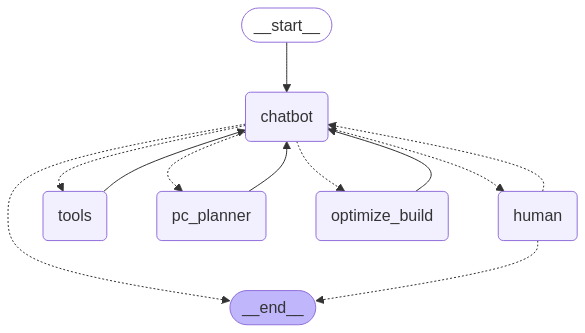

Note: The library used here for visualization sometimes takes a long time to render and the program encounters a HTTP Connection lost exception. That is not a bug with our app, as running the exact same cell in a row successively will eventually work (with no other changes being made elsewhere).

Thus, the below draw statement is being commented out, but when it works, it will look just like the image above.

In [ ]:
# Visualize the graph created.
# Below line is commented out due to intermittently causing errors. Comment back in to try it out.
# Image(chat_graph.get_graph().draw_mermaid_png())

In [ ]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# being able to try multiple steps and chatting for longer.
config = {"recursion_limit": 100}

# Invocation of the agent workflow, starts the whole app.
state = chat_graph.invoke({"messages": []}, config)
print('Program successfully exited.')

# pprint(state)

## ✅ Conclusion

This notebook demonstrates how you can use **LangGraph + Gemini + real-time search + a scoring engine** to build a practical, domain-specific agent that solves a real-world problem.

You've seen how the agent:
- Talks to users
- Understands needs
- Searches online
- Ranks results
- Returns complete recommendations — all while remembering context and adapting intelligently

This is a great example of how Generative AI can move beyond text generation to become a full-fledged problem-solving agent, **allowing users to get help with a variety of domain-specific problems!** We would love to come do more at Google (and especially @ DeepMind!) and help with anything you may need, so if you like what you see, don't hesitate to look through our profiles! 😉

 \- 🐶 [Adam](https://www.linkedin.com/in/adam-steinmetz-6463a4240/) and 🤖 [Daniel](https://theaughat.github.io/personal-portfolio/)

## 🧭 Next Steps

- **Graphical User Interface (GUI):** Incorporate an interactive UI via *Gradio* or *Streamlit* to make it easier for our users to interact with the agent
- **RAG-based Question Answering:** A new tool that detects whether the user is asking knowledge or installation related questions about the parts or specific builds, and query a knowledge base with embedded specifically focused on this
- **Improved Online Searching:** We plan to improve our searching strategies so the solutions provided to the user are more robust and hallucination-free
- **Improved Search Results:** Fix markdown generation for final recommendations and try to include images of the parts mentioned
- **Better Price Comparisons and Indication:** For custom PCs, average out the prices of each part type and indicate the proportion of the budget needed for it.

If you're interested in seeing these improvements and any new projects by us in the future, feel free to follow us using the links provided above!